# Blob Detection using Laplacian of Gaussian and Scale-Space Extrema

In [1]:
# Import libraries
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

## Pre-processing the Image

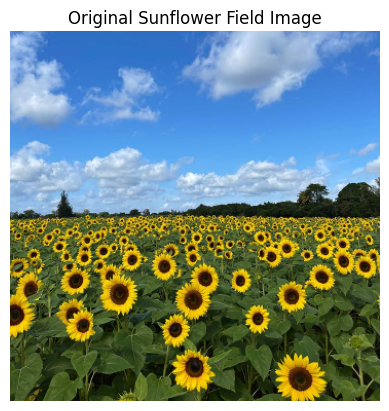

In [3]:
# Import libraries
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load the image
im = cv.imread('images/the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)

# Display the image
plt.imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB))
plt.title("Original Sunflower Field Image")
plt.axis("off")
plt.show()


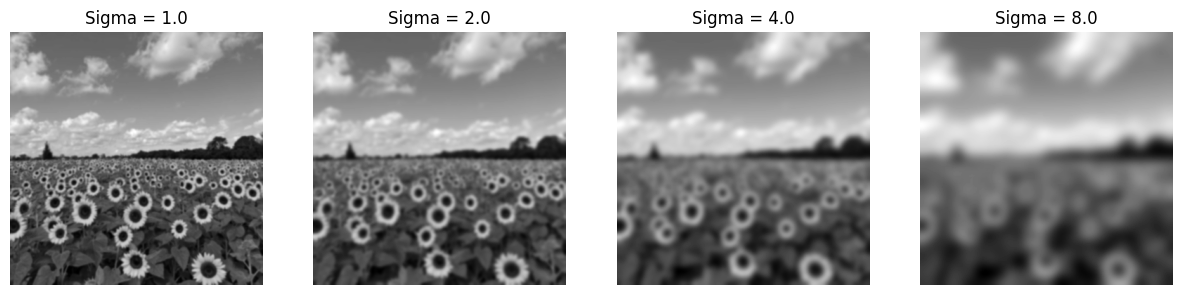

In [5]:
# Define sigma values
sigma_values = [1.0, 2.0, 4.0, 8.0]

# Display blurred images for different sigmas
fig, axs = plt.subplots(1, len(sigma_values), figsize=(15, 5))
for i, sigma in enumerate(sigma_values):
    blurred = cv.GaussianBlur(gray, (0, 0), sigma)
    axs[i].imshow(blurred, cmap='gray')
    axs[i].set_title(f'Sigma = {sigma}')
    axs[i].axis('off')
plt.show()


## Applying the Laplacian of Gaussian (LoG)

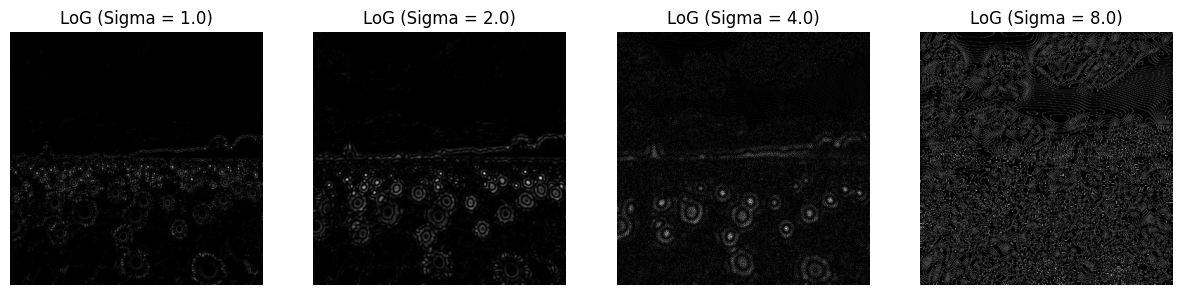

In [6]:
# Apply LoG and visualize the results
fig, axs = plt.subplots(1, len(sigma_values), figsize=(15, 5))
log_images = []
for i, sigma in enumerate(sigma_values):
    blurred = cv.GaussianBlur(gray, (0, 0), sigma)
    log_image = cv.Laplacian(blurred, cv.CV_64F)
    log_image = np.square(log_image)
    log_images.append(log_image)
    axs[i].imshow(log_image, cmap='gray')
    axs[i].set_title(f'LoG (Sigma = {sigma})')
    axs[i].axis('off')
plt.show()